1. Import ground truth from tsv into dataframe
2. Create labels with rtmin, rtmax, mzmin, mzmax scaled into image dimensions:
    2a. 100,000px height for 0-1000mz range (.01 mz/ px)
    2b. 1500px width for 0-30min (0-1800sec) rt range (1.2 sec/ px)

In [ ]:
#this cell creates one label per cluster, 
#which we stopped doing in favor of one label per feature
import csv
import pandas as pd
import numpy as np

df = pd.read_csv('191016_meyer_neg.tsv',sep = '\t')
n = max(df['cluster_id'])
labels = np.zeros((n,4))

df = pd.read_csv('191016_meyer_neg.tsv', index_col = 'cluster_id',sep = '\t')
for i in range(n):
    if len(df.loc[i].shape) == 1:
        labels[i] = [(df.loc[i]['rtmin']) * (5/6), (df.loc[i]['rtmax']) * (5/6), (df.loc[i]['mzmin']) * 100, (df.loc[i]['mzmax']) * 100 ]
    else:
        labels[i] = [min(df.loc[i]['rtmin']) * (5/6), max(df.loc[i]['rtmax']) * (5/6), min(df.loc[i]['mzmin']) * 100, max(df.loc[i]['mzmax']) * 100 ]


In [35]:
#one label per feature
import csv
import pandas as pd
import numpy as np

df = pd.read_csv('191016_meyer_neg.tsv',sep = '\t')
labels = np.zeros((len(df),4))

for i, row in df.iterrows():
    labels[i] = [row['rtmin']*(5/6), row['rtmax']*(5/6), row['mzmin']*100, row['mzmax']*100]
    

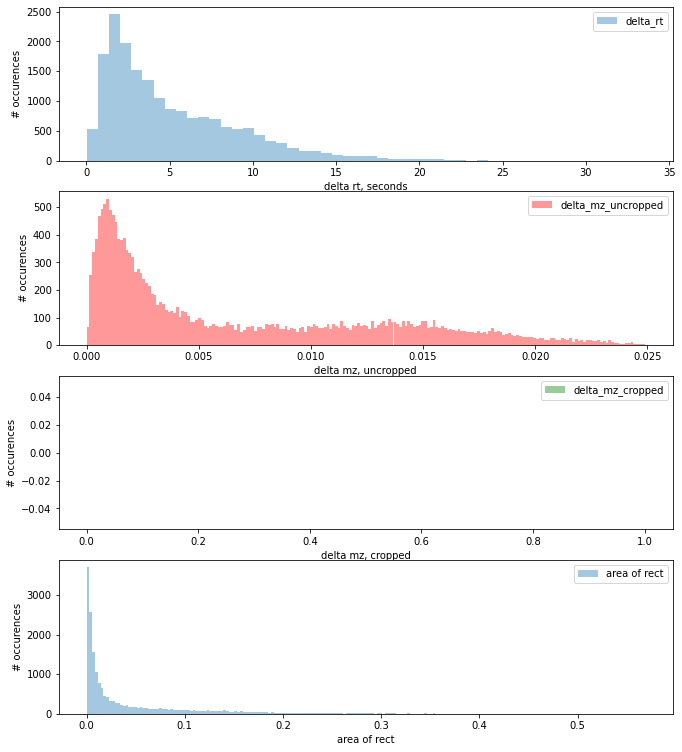

In [36]:
import seaborn as sb

delta_rt = [(l[1] - l[0])*(6/5) for l in labels]
delta_mz = [(l[3] - l[2])/100 for l in labels]

delta_mz_2 =[i for i in delta_mz if i>5]

area = [mz * rt for mz, rt in zip(delta_mz, delta_rt)]

f, axes = plt.subplots(4, 1, figsize=(11, 13), sharex=False)
ax1 = sb.distplot(delta_rt,kde=False,norm_hist=False,ax = axes[0],label='delta_rt')
ax1.set(xlabel = 'delta rt, seconds', ylabel = '# occurences')

ax2 = sb.distplot(delta_mz,bins=200,kde=False,norm_hist=False,color='red',ax=axes[1],label='delta_mz_uncropped')
ax2.set(xlabel = 'delta mz, uncropped', ylabel = '# occurences')

ax3 = sb.distplot(delta_mz_2,bins=100,kde=False,norm_hist=False,color='green',ax=axes[2],label='delta_mz_cropped')
ax3.set(xlabel = 'delta mz, cropped', ylabel = '# occurences')

ax4 = sb.distplot(area,bins=200,kde=False,ax=axes[3],label='area of rect')
ax4.set(xlabel = 'area of rect', ylabel = '# occurences')

ax1.legend(), ax2.legend(),ax3.legend(),ax4.legend()

plt.show()
f.savefig('hist_fig.png')

### labels should be nx4 array, where n is number of features and 4 are positions of bounding box

Create blank "template image" to add labels onto to create our "ground truth" mask for training.

Use cv.rectangle to create template and add features as boxes onto blank image. 

Second cell uses mpatches.Rectangle to superimpose rectangles onto image from raw data.

In [ ]:
import cv2 as cv
import matplotlib.pyplot as plt

template = np.zeros((100000,1500))

for f in labels:
    start_point = (int(f[0]),int(f[2]))
    end_point = (int(f[1]),int(f[3]))
    template = cv.rectangle(template, start_point, end_point, (255,255,255), -1) 


fig, ax = plt.subplots(figsize=(100,100))
ax.imshow(template, cmap=plt.cm.gray)
ax.axis('off')
cv.imwrite("/home/rcardiff/ryan/ryan/290320_test/label_img.png", template)

In [ ]:
import cv2 as cv
import matplotlib.pyplot as plt
from skimage import feature
from skimage.measure import regionprops
import matplotlib.patches as mpatches
from skimage.morphology import label

image = cv.imread("/home/rcardiff/ryan/ryan/test_files/combined_img.png",0)
fig, ax = plt.subplots(figsize=(100,100))
ax.imshow(image, cmap=plt.cm.gray)
ax.axis('off')

for feature in labels:
    #lower left position, width, height: (maxmz, minrt), maxrt-minrt, minmz-maxmz
    minrt,maxrt,minmz,maxmz = feature
    rect = mpatches.Rectangle((minrt, minmz),
                              maxrt - minrt,
                              maxmz - minmz,
                              fill=False,
                              edgecolor='red',
                              linewidth=.1)
    ax.add_patch(rect)



plt.tight_layout()
plt.show()
ax.figure.savefig('/home/rcardiff/ryan/ryan/label_img_1.png')

Now, we partition our label image into several smaller images so that feature level information is not lost during training.

In [3]:
#Generate image partitions using PIL library
from PIL import Image

image_frame = Image.open("/home/rcardiff/ryan/ryan/290320_test/meyer_pos.png")
#image_mask = Image.open("/home/rcardiff/ryan/ryan/290320_test/label_img.png")

x_partitions = 6
y_partitions = 200

x_step = int(image_frame.width/x_partitions)
y_step = int(image_frame.height/y_partitions)


for j in range(x_partitions):
    for i in range(y_partitions):
        i_range = i*y_step
        j_range = j*x_step
        image_frame_crop = image_frame.crop((j_range, i_range, x_step+j_range, y_step+i_range)).save('/home/rcardiff/ryan/ryan/290320_test/Frames_pos/img'+str(j).zfill(2)+str(i).zfill(3)+'.png')
        #image_mask_crop = image_mask.crop((j_range, i_range, x_step+j_range, y_step+i_range)).save('/home/rcardiff/ryan/ryan/290320_test/Masks/img'+str(j).zfill(2)+str(i).zfill(3)+'.png')




Separate images into training, validation, and test set. Generate folders to organize different sets.

In [2]:
#From Rwiddhi Chakraborty
#https://towardsdatascience.com/a-keras-pipeline-for-image-segmentation-part-1-6515a421157d

import os
import shutil
import random
import re
from PIL import Image

DATA_PATH = '/home/rcardiff/ryan/ryan/290320_test/'
FRAME_PATH = DATA_PATH+'Frames_IC/'
MASK_PATH = DATA_PATH+'Masks/'


# Create folders to hold images and masks
folders = ['train_frames', 'train_masks', 'val_frames', 'val_masks', 'test_frames', 'test_masks']


for folder in folders:
    if os.path.isdir(DATA_PATH + folder):
        shutil.rmtree(DATA_PATH + folder)
    os.makedirs(DATA_PATH + folder)
  
  
# Get all frames and masks, sort them, shuffle them to generate data sets.
all_frames = os.listdir(FRAME_PATH)
all_masks = os.listdir(MASK_PATH)

# TODO: Find out what re.findall is doing...
all_frames.sort(key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)])
all_masks.sort(key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)])


random.seed(230)
random.shuffle(all_frames)


# Generate train, val, and test sets for frames
train_split = int(0.7*len(all_frames))
val_split = int(0.9 * len(all_frames))

train_frames = all_frames[:train_split]
val_frames = all_frames[train_split:val_split]
test_frames = all_frames[val_split:]


# Generate corresponding mask lists for masks
train_masks = [f for f in all_masks if f in train_frames]
val_masks = [f for f in all_masks if f in val_frames]
test_masks = [f for f in all_masks if f in test_frames]


#Add train, val, test frames and masks to relevant folders
def add_frames(dir_name, image):
    img = Image.open(FRAME_PATH+image)
    img.save(DATA_PATH+'/{}'.format(dir_name)+'/'+image)
    return

def add_masks(dir_name, image):
    img = Image.open(MASK_PATH+image)
    img.save(DATA_PATH+'/{}'.format(dir_name)+'/'+image)
    return


frame_folders = [(train_frames, 'train_frames'), (val_frames, 'val_frames'), 
                 (test_frames, 'test_frames')]
mask_folders = [(train_masks, 'train_masks'), (val_masks, 'val_masks'), 
                (test_masks, 'test_masks')]

# Add frames
for folder in frame_folders:
    folders = [f for f in folder[0] if f.endswith('.png')]
    array = folders
    name = [folder[1]] * len(array)
    list(map(add_frames, name, array))
         
    
# Add masks
for folder in mask_folders:
    folders = [f for f in folder[0] if f.endswith('.png')]
    array = folders
    name = [folder[1]] * len(array)
    list(map(add_masks, name, array))

In [3]:
DATA_PATH = '/home/rcardiff/ryan/ryan/290320_test/'
folders = ['train_frames', 'train_masks', 'val_frames', 'val_masks']

for folder in folders:
    files = os.listdir(DATA_PATH+folder)
    dest = DATA_PATH+folder+'/'+folder.split('_')[0]
    os.makedirs(dest)
    
    for f in files:
        shutil.move(os.path.join(DATA_PATH,folder,f), dest)

Test to make sure we are running on GPU for speed improvements.

In [4]:
import tensorflow as tf
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10438061675984692525
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 11273525442383289308
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 11098353038865272238
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10738165376
locality {
  bus_id: 2
  numa_node: 1
  links {
  }
}
incarnation: 10361877170005804808
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:41:00.0, compute capability: 6.1"
]
Num GPUs Available:  1


### Image Data Generators as inputs into our model


In [5]:
import random
import numpy as np
import cv2
import os

def data_gen(img_folder, mask_folder, batch_size):
    c = 0
    n = os.listdir(img_folder) #List of training images
    n = [i for i in n if i.endswith('.png')]
    random.shuffle(n)
  
    input_size = [256,256]
    while (True):
        img = np.zeros((batch_size, input_size[0], input_size[1], 1)).astype('float')
        mask = np.zeros((batch_size, input_size[0], input_size[1], 1)).astype('float')
        #img = np.zeros((batch_size, 256, 1024, 1)).astype('float')
        #mask = np.zeros((batch_size, 256, 1024, 1)).astype('float')
        
        
        for i in range(c, c+batch_size): 
            train_img = cv2.imread(img_folder+'/'+n[i], cv2.IMREAD_GRAYSCALE)/255.
            train_img =  cv2.resize(train_img, (input_size[0],input_size[1]))
            train_img = train_img.reshape(input_size[0], input_size[1], 1)
                
            img[i-c] = train_img #add to array - img[0], img[1], and so on.

            train_mask = cv2.imread(mask_folder+'/'+n[i], cv2.IMREAD_GRAYSCALE)/255.
            train_mask = cv2.resize(train_mask, (input_size[0],input_size[1]))
            train_mask = train_mask.reshape(input_size[0], input_size[1], 1) 

            mask[i-c] = train_mask

        c+=batch_size
        if(c+batch_size>=len(os.listdir(img_folder))):
            c=0
            random.shuffle(n)

        yield img, mask

    
train_frame_path = '/home/rcardiff/ryan/ryan/290320_test/train_frames/train/'
train_mask_path = '/home/rcardiff/ryan/ryan/290320_test/train_masks/train/'

val_frame_path = '/home/rcardiff/ryan/ryan/290320_test/val_frames/val/'
val_mask_path = '/home/rcardiff/ryan/ryan/290320_test/val_masks/val/'

train_gen = data_gen(train_frame_path,train_mask_path, batch_size = 4)
val_gen = data_gen(val_frame_path,val_mask_path, batch_size = 4)

### What Is the Difference Between Batch and Epoch?

The batch size is a number of samples processed before the model is updated.

The number of epochs is the number of complete passes through the training dataset.

### Here comes the meat.

Below, we define the UNet model. Refer to slides for more info:
https://docs.google.com/presentation/d/1FcM-lg0ZmuP86M_PXEMXrKzVeOeFffV0CZgPGcu_cpw/edit?usp=sharing

In [6]:
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

def unet(pretrained_weights = None,input_size = (256,256,1)):

    m_inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(m_inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = m_inputs, outputs = conv10)
    
    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model




Using TensorFlow backend.


### Compile and fit model:

    -Choose no. of epochs, batch size
    -Define optimizer and parameters, loss function, metrics
    -Choose any callbacks you want to include
    -fit model and save weights for testing

In [7]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import CSVLogger
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras import losses
import os
from keras import metrics



NO_OF_TRAINING_IMAGES = len(os.listdir('/home/rcardiff/ryan/ryan/290320_test/train_frames/train'))
NO_OF_VAL_IMAGES = len(os.listdir('/home/rcardiff/ryan/ryan/290320_test/val_frames/val'))

NO_OF_EPOCHS = 30

BATCH_SIZE = 8

weights_path = '/home/rcardiff/ryan/ryan/290320_test/weights/'

m = unet()
opt = Adam(lr=1E-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

 
m.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['accuracy' ] )#, metrics.FalseNegatives()])

          
#checkpoint = ModelCheckpoint(weights_path, monitor='accuracy', verbose=1, save_best_only=True, mode='max')

#csv_logger = CSVLogger('train_log.csv', append=True, separator=';')

#earlystopping = EarlyStopping(monitor = 'accuracy', verbose = 1, min_delta = 0.01, patience = 3, mode = 'max')

#A callback is a set of functions to be applied at given stages of the training procedure. You can use callbacks to get a view on internal states and statistics of the model during training.

callbacks_list = []


In [8]:
results = m.fit(train_gen, epochs=NO_OF_EPOCHS, 
                          steps_per_epoch = (NO_OF_TRAINING_IMAGES//BATCH_SIZE),
                          validation_data=val_gen, 
                          validation_steps=(NO_OF_VAL_IMAGES//BATCH_SIZE), 
                          callbacks=callbacks_list)
m.save('/home/rcardiff/ryan/ryan/290320_test/Model_IC.h5')


Epoch 1/30
105/105 [==============================] - 24s 224ms/step - loss: 0.0418 - accuracy: 0.9978 - val_loss: 0.0017 - val_accuracy: 0.9974
Epoch 2/30
105/105 [==============================] - 20s 187ms/step - loss: 0.0059 - accuracy: 0.9980 - val_loss: 0.0092 - val_accuracy: 0.9981
Epoch 3/30
105/105 [==============================] - 20s 189ms/step - loss: 0.0063 - accuracy: 0.9977 - val_loss: 0.0112 - val_accuracy: 0.9976
Epoch 4/30
105/105 [==============================] - 20s 189ms/step - loss: 0.0054 - accuracy: 0.9981 - val_loss: 0.0139 - val_accuracy: 0.9977
Epoch 5/30
105/105 [==============================] - 20s 190ms/step - loss: 0.0058 - accuracy: 0.9978 - val_loss: 0.0107 - val_accuracy: 0.9976
Epoch 6/30
105/105 [==============================] - 20s 191ms/step - loss: 0.0052 - accuracy: 0.9981 - val_loss: 0.0067 - val_accuracy: 0.9979
Epoch 7/30
105/105 [==============================] - 20s 190ms/step - loss: 0.0059 - accuracy: 0.9978 - val_loss: 0.0139 - val_ac

Data generator for test set - same as other generator but doesn't require two file paths (no validation set). Also made a second version for testing just a single image (not a folder).

In [6]:
import numpy as np
import os
import cv2

def testGenerator(img_folder, target_size = (256,256)):
    n = sorted(os.listdir(img_folder)) #List of training images
    
    while (True):
        if '.ipynb_checkpoints' in n:
            n.remove(n[0])
            
        img = np.zeros((len(n), target_size[0], target_size[1], 1)).astype('float')
        
        for i in range(len(n)):
            if n[i].endswith('.png'):
                test_img = cv2.imread(img_folder+'/'+n[i], cv2.IMREAD_GRAYSCALE)/255.
                test_img =  cv2.resize(test_img, (target_size)) # Read an image from folder and resize
                test_img = test_img.reshape(target_size[0], target_size[1], 1)
                img[i] = test_img
            
        yield img
        
def testGenerator_single(img_path, target_size = (256,256)):
    
    while (True):
        img = np.zeros((1, target_size[0], target_size[1], 1)).astype('float')
        
        if img_path.endswith('.png'):
                test_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)/255.
                test_img =  cv2.resize(test_img, (target_size))
                test_img = test_img.reshape(target_size[0], target_size[1], 1)
                img[0] = test_img

        yield img

Evaluate model on test set using m.predict_generator or m.predict (they should give the same result).

If running into memory errors, split test images into smaller groups then load into test_gen and predict.

In [11]:
from keras.models import *

m = load_model('/home/rcardiff/ryan/ryan/290320_test/weights/Model_IC.h5')

test_frame_path_1 = '/home/rcardiff/ryan/ryan/290320_test/test_frames/test_1'
test_gen_1 = testGenerator(test_frame_path_1)
results_1 = m.predict_generator(test_gen_1,steps = 1,verbose = 1)

test_frame_path_2 = '/home/rcardiff/ryan/ryan/290320_test/test_frames/test_2'
test_gen_2 = testGenerator(test_frame_path_2)
results_2 = m.predict_generator(test_gen_2,steps = 1,verbose = 1)

results = np.concatenate((results_1,results_2))
np.save('/home/rcardiff/ryan/ryan/290320_test/weights/IC_results.npy', results)

1/1 [==============================] - 4s 4s/step


In [12]:
results = np.load('/home/rcardiff/ryan/ryan/290320_test/weights/IC_results.npy')
print(results.shape)

(121, 256, 256, 1)


Ok, let's see what these predictions look like. We arbitrarily choose a threshold of .15 for the prediction but this can (and should) be tinkered with, maybe by looking at histogram of pixel values.

Using TensorFlow backend.


(-0.5, 255.5, 255.5, -0.5)

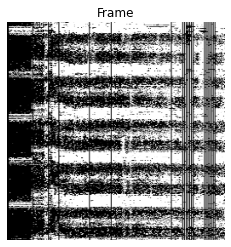

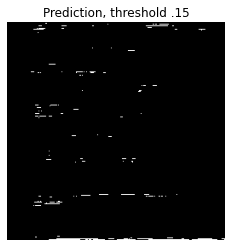

In [9]:
import numpy as np
from matplotlib import pyplot as plt

#from keras.models import *
#m = load_model('/home/rcardiff/ryan/ryan/290320_test/weights/Model_IC.h5')

frame = cv2.imread('/home/rcardiff/ryan/ryan/290320_test/Frames_pos/frames_01/img00061.png',cv2.IMREAD_GRAYSCALE)
frame = cv2.resize(frame, (256,256))
#mask = cv2.imread('/home/rcardiff/ryan/ryan/290320_test/test_masks/img00093.png',cv2.IMREAD_GRAYSCALE)
#mask = cv2.resize(mask, (256,256))
testgen = testGenerator_single('/home/rcardiff/ryan/ryan/290320_test/Frames_pos/frames_01/img00061.png')
result = m.predict(testgen, steps = 1)

plt.imshow(frame,cmap = plt.cm.gray)
plt.title('Frame')
plt.axis('off')
plt.figure()
#plt.imshow(mask,cmap = plt.cm.gray)
#plt.title('Mask')
#plt.axis('off')
#plt.figure()
plt.imshow(result.reshape((256,256))>.15, cmap = plt.cm.gray)
plt.title('Prediction, threshold .15')
plt.axis('off')

The next step we want is to **run a prediction on every single image** (which presents obvious errors in that we will be testing on images we trained on, but that's a problem for later) and then **stitch images together to create full image size prediction**.

From there, we can try running watershed on our prediction-image to try and extract features from.

First, we need to split up the frames into small enough batches so we can run predict without memory issues.

In [4]:
import os
import shutil

img_folder = '/home/rcardiff/ryan/ryan/290320_test/Frames_pos/'
n = sorted(os.listdir(img_folder))
if '.ipynb_checkpoints' in n:
    n.remove(n[0])

img_per_batch = 60
n_batches = int(len(n)/img_per_batch)

for i in range(n_batches):
    new_dir = img_folder + 'frames_'+ str(i).zfill(2)
    if os.path.isdir(new_dir):
        shutil.rmtree(new_dir)
    os.makedirs(new_dir)
    loc = i*img_per_batch
    for i in n[loc:loc+img_per_batch]:
        os.rename(img_folder+i,new_dir+'/'+i)
    

In [ ]:
#this is an equivalent way of producing same result
c = 0
k = 0
new_folder = img_folder + 'frames_' + str(k).zfill(2)
os.makedirs(new_folder)

for file in sorted(os.listdir(img_folder)):
    shutil.move(img_folder+file,new_folder+file)
    c+=1
    if c=60:
        k+=1
        c=0
        new_folder = img_folder+'frames_'+str(k).zfill(2)
        os.makedirs(new_folder)
        


Generate predictions on each batch

In [10]:
result_list = []
frame_dir = '/home/rcardiff/ryan/ryan/290320_test/Frames_pos/'

n = sorted(os.listdir(frame_dir))
if '.ipynb_checkpoints' in n:
    n.remove(n[0])
    
for folder in n:
    path = frame_dir+folder
    test_gen = testGenerator(path)
    predict = m.predict_generator(test_gen, steps = 1)
    result_list.append(predict)

In [11]:
result_full = np.concatenate(result_list)
np.save('/home/rcardiff/ryan/ryan/290320_test/Predictions/predictions_pos.npy', result_full)

In [12]:
result = np.load('/home/rcardiff/ryan/ryan/290320_test/Predictions/predictions_pos.npy')
result = result.flatten()

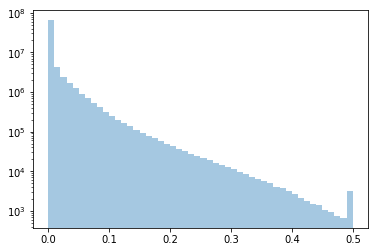

In [13]:
import seaborn as sns

fig, ax = plt.subplots()
plt.yscale('log')
sns.distplot(result,kde=False,ax = ax)


In [14]:
from PIL import Image
import os

file_path = '/home/rcardiff/ryan/ryan/290320_test/Predictions/meyer_pos/'
os.makedirs(file_path)

for i,p in enumerate(result_full):
    p = p.reshape((256,256))>.15 # or *255
    im = Image.fromarray(p).convert('L')
    im.save(file_path+'img_'+str(i).zfill(4)+'.png')
    

In [15]:
from PIL import Image

c = 0
path = '/home/rcardiff/ryan/ryan/290320_test/Predictions/meyer_pos/'
predictions = sorted(os.listdir(path))

if '.ipynb_checkpoints' in predictions:
    predictions.remove(predictions[0])
    
result = Image.new('L',(0,0))
result_list = []

for p in predictions:
    frame_add = Image.open(path+p)
    (width1, height1) = result.size
    (width2, height2) = frame_add.size

    result_width = max(width1,width2)
    result_height = height1 + height2
        
    temp = Image.new('L', (result_width, result_height))
    temp.paste(im=result, box=(0, 0))
    temp.paste(im=frame_add, box=(0, height1))
    result = temp
    c+=1
    if c%200==0:
        result_list.append(result)
        result = Image.new('L',(0,0))

full_result = Image.new('L',(result_list[0].size[0]*6,result_list[0].size[1]))
for i in range(6):
    full_result.paste(im=result_list[i], box=(i*256,0))

In [16]:
full_result
full_result.save('/home/rcardiff/ryan/ryan/290320_test/prediction_full_result_pos.png')

For visualizing MS data: https://www.openms.de/tutorials/

In [17]:
#Watershed on combined image region
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

img = cv.imread('/home/rcardiff/ryan/ryan/290320_test/prediction_full_result_pos.png')
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
gray_inv = np.invert(gray)

kernel1 = np.array([[-1,-1, -1], [0, 0, 0], [1, 1, 1]], np.uint8)
opening = cv.morphologyEx(gray_inv,cv.MORPH_OPEN,kernel1, iterations = 3)
#opening = dilation. turns pixel to 1 if a pixel under the kernel is 1, increasing size of object and 
#helping connect broken objects

kernel2 = np.ones((3,3),np.uint8)
grad = cv.morphologyEx(opening,cv.MORPH_GRADIENT, kernel2, iterations =1)


# Marker labelling
ret, markers = cv.connectedComponents(grad)
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1
markers = cv.watershed(img,markers)

from skimage.measure import regionprops
print(len(regionprops(markers)))

34648


In [18]:
import matplotlib.patches as mpatches
import os
from statistics import median
from tqdm import tqdm_notebook as tqdm
import numpy as np

feature_data = [x.bbox for x in regionprops(markers)]
feature_list = [{} for x in regionprops(markers)]

min_mzs = np.array([x[0] for x in feature_data])
min_rts = np.array([x[1] for x in feature_data])
max_mzs = np.array([x[2] for x in feature_data])
max_rts = np.array([x[3] for x in feature_data])

min_rts = np.round(min_rts * (1800/1536), decimals = 4)
min_mzs = np.round(min_mzs * (1000/51200), decimals = 4)
max_rts = np.round(max_rts * (1800/1536), decimals = 4)
max_mzs = np.round(max_mzs * (1000/51200), decimals = 4)


num_features = len(min_mzs)

In [23]:
import pandas as pd
import seaborn as sb

df = pd.DataFrame({'min mz': min_mzs, 'max mz': max_mzs, 'min rt': min_rts, 'max rt': max_rts})
meyer = pd.read_csv('/home/rcardiff/ryan/ryan/191016_meyer_pos.tsv', sep='\t')
print(len(meyer))

32981


/root/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (51,55,56,65,66,71,72,74,75) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(<matplotlib.legend.Legend at 0x7f5eec127c10>,
 <matplotlib.legend.Legend at 0x7f5ecc4d9c90>)

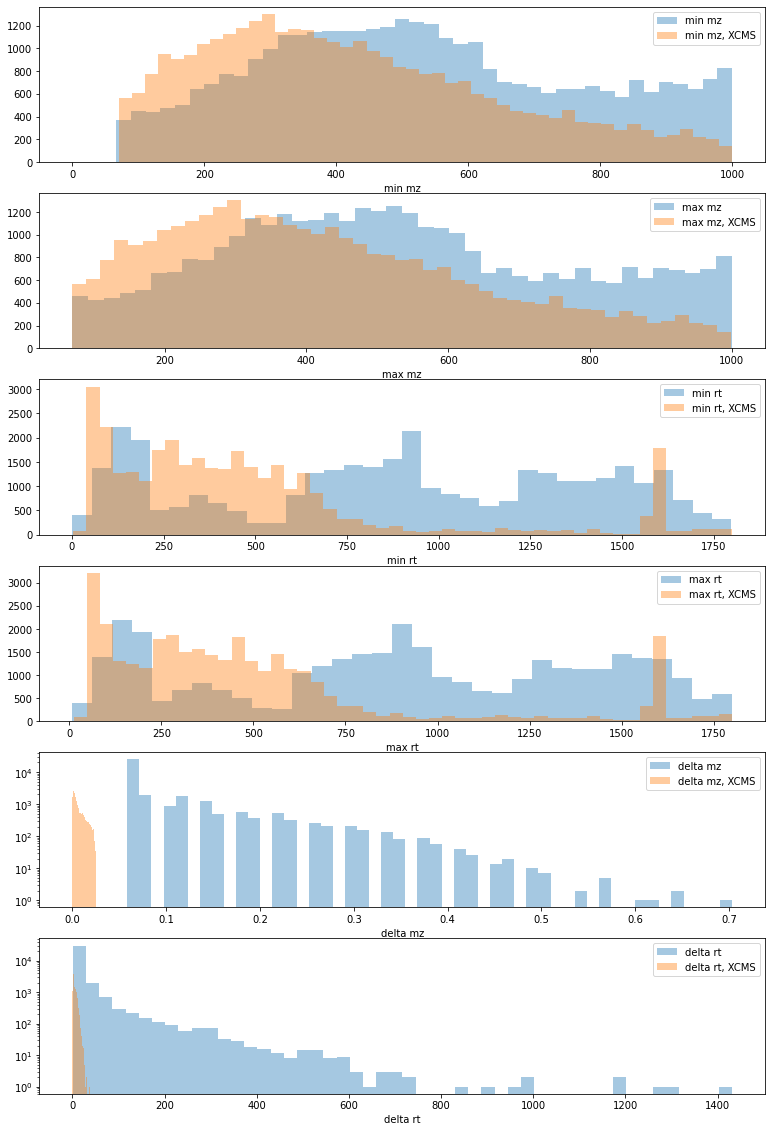

In [20]:
f, axes = plt.subplots(6, 1, figsize = (13,20), sharex=False)
ax1 = sb.distplot(df['min mz'],kde=False,norm_hist=False,ax = axes[0],label='min mz')
ax1 = sb.distplot(meyer['mzmin'],kde=False,norm_hist=False,ax = axes[0],label='min mz, XCMS')
ax1.set(xlabel = 'min mz')

ax2 = sb.distplot(df['max mz'],kde=False,norm_hist=False,ax = axes[1],label='max mz')
ax2 = sb.distplot(meyer['mzmax'],kde=False,norm_hist=False,ax = axes[1],label='max mz, XCMS')
ax2.set(xlabel = 'max mz')

ax3 = sb.distplot(df['min rt'],kde=False,norm_hist=False,ax = axes[2],label='min rt')
ax3 = sb.distplot(meyer['rtmin'],kde=False,norm_hist=False,ax = axes[2],label='min rt, XCMS')
ax3.set(xlabel = 'min rt')

ax4 = sb.distplot(df['max rt'],kde=False,norm_hist=False,ax = axes[3],label='max rt')
ax4 = sb.distplot(meyer['rtmax'],kde=False,norm_hist=False,ax = axes[3],label='max rt, XCMS')
ax4.set(xlabel = 'max rt')

ax5 = sb.distplot(df['max mz'] - df['min mz'][1:],kde=False,norm_hist=False,ax = axes[4],label='delta mz')
ax5 = sb.distplot(meyer['mzmax'] - meyer['mzmin'], kde=False,norm_hist=False,ax = axes[4],label='delta mz, XCMS')
ax5.set(xlabel = 'delta mz')
ax5.set(yscale = 'log')
#ax5.set_xlim(0,1)

ax6 = sb.distplot(df['max rt'] - df['min rt'][1:],kde=False,norm_hist=False,ax = axes[5],label='delta rt')
ax6 = sb.distplot(meyer['rtmax'] - meyer['rtmin'], kde=False,norm_hist=False,ax = axes[5],label='delta rt, XCMS')
ax6.set(xlabel = 'delta rt')
ax6.set(yscale = 'log')

ax1.legend(), ax2.legend(),ax3.legend(),ax4.legend(),ax5.legend(),ax6.legend()
